# MNIST Dataset

MNIST คือ ชุดข้อมูลรูปภาพของตัวเลขอารบิก 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ที่เขียนด้วยลายมือ <br>
เป็นรูปขาวดำ Grayscale ความละเอียด Resolution กว้าง x ยาว $28 \times 28$ Pixel 


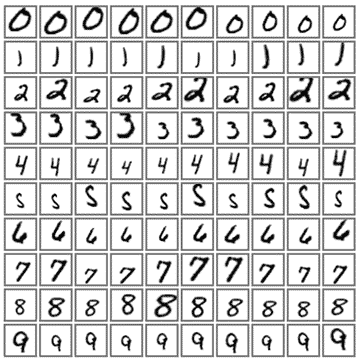

# Setup

## Import Libraries

In [122]:
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split

from torchinfo import summary
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Preparation

### Data Augmentation

ส่วนนี้ในการ transform เราสามารถทำการ augment ข้อมูลได้ เช่น การหมุน การพลิก การปรับความสว่าง เป็นต้น

สามารถดูตัวอย่างการ augment พร้อมโค้ด ข้อมูลได้ที่ [Website ของ PyTorch](https://docs.pytorch.org/vision/0.19/auto_examples/transforms/plot_transforms_illustrations.html)

In [124]:
# mean and std for monochrome color
mean = [0.5]
std = [0.5]

# mean and std for RGB color (ไม่ได้ใช้เนื่องจากว่าภาพ MNIST เป็นภาพขาวดำ)
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToImage(), 

    # สามารถใส่เพิ่มได้ให้ข้อมูลมีความหลากหลายมากขึ้น

    # example: uncomment ถ้าอยากใช้

    # transforms.RandomHorizontalFlip(p = 0.5),
    # transforms.RandomRotation(degrees=(0, 45)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.9, 1.1), fill=-1),

    
    
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([ # Test set จะไม่ augment เพ่ิม
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std)],
)

### Load dataset with augmentation

In [125]:
train_and_val_set = datasets.MNIST('data/MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('data/MNIST/', download=True, train=False, transform=transform_test)

train_size = int(0.8 * len(train_and_val_set))
val_size = len(train_and_val_set) - train_size

trainset, valset = random_split(train_and_val_set, [train_size, val_size])

print(
    "Train size: ",      len(trainset), "\n",
    "Validation size: ", len(valset),   "\n",
    "Test size: ",       len(testset),  "\n",
    sep=""
)

Train size: 48000
Validation size: 12000
Test size: 10000



#### ตัวอย่างการใส่ Data Augmentation

Example Augmentation


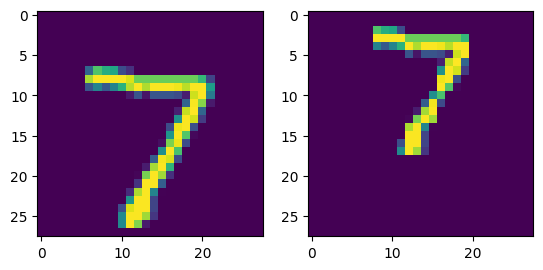

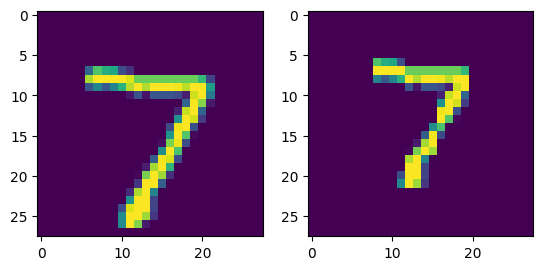

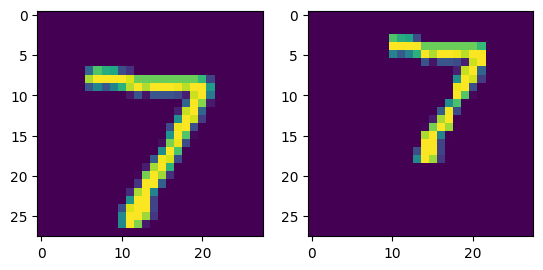

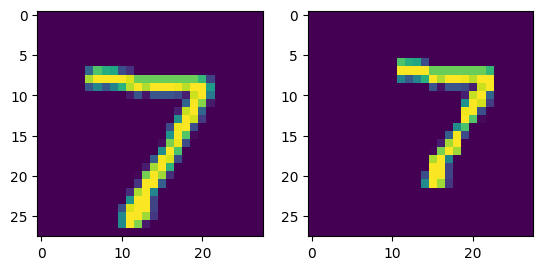

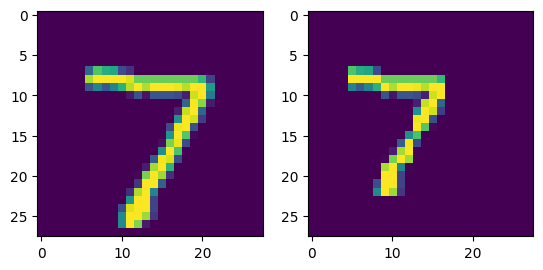

In [126]:
af = transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2), scale=(0.8, 0.8), fill=-1)
print("Example Augmentation")
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(testset[0][0].numpy().squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(tmp := af(testset[0][0]).numpy().squeeze())
    plt.show()

### DataLoader

In [127]:
BATCH_SIZE = 1024

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# CNN

## Define CNN Model

In [147]:
class Conv2dAndReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Conv2dAndReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv(x))

class LinearAndReLU(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearAndReLU, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.linear(x))

class SimpleCNNClassification(nn.Module):
    def __init__(self):
        super(SimpleCNNClassification, self).__init__()
        self.conv1 = Conv2dAndReLU(1, 32, kernel_size=3, padding=1)  #  1 channel (ภาพขาวดำ) -> 32 channels (feature maps)
        self.conv2 = Conv2dAndReLU(32, 12, kernel_size=3, padding=1) #  32 feature maps -> 64 feature maps
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.fc1 = LinearAndReLU(12 * 7 * 7, 128) # 12 feature maps (7x7) -> 128 neurons
        self.fc2 = nn.Linear(128, 10) # 128 neurons -> 10 output classes (0-9) (No ReLU)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = self.fc2(x) # No ReLU
        return x

NOTE="""
    อธิบายเพิ่มเติมใน function `forward`: 
        ภาพ MNIST มีขนาด 28x28 pixels และมี 1 channel (ขาวดำ)
        1. หลังผ่านการทำ Convolution รอบแรก (conv1) จะได้ 32 feature maps ขนาด 28x28 (ขนาดภาพเท่าเดิม)
        2. หลังผ่าน MaxPooling รอบแรก จะได้ขนาด 14x14 (ลดขนาดลงครึ่งหนึ่ง)
        3. หลังผ่านการทำ Convolution รอบที่สอง (conv2) จะได้ 12 feature maps ขนาด 14x14
        4. หลังผ่าน MaxPooling รอบที่สอง จะได้ขนาด 7x7 (ลดขนาดลงครึ่งหนึ่งอีกครั้ง)
        5. Flattening จะเปลี่ยนจาก 12 feature maps ขนาด 7x7 เป็นเวกเตอร์ขนาด 12 * 7 * 7 = 588
        6. ผ่าน Fully Connected Layer แรก (fc1) จะได้ 128 neurons
        7. ผ่าน Fully Connected Layer สุดท้าย (fc2) จะได้ 10 neurons สำหรับการจำแนกประเภทตัวเลข 0-9
        8. ใช้ ReLU activation function ในทุกชั้นยกเว้นชั้นสุดท้าย (เขียนรวมใน Conv2dAndReLU และ LinearAndReLU ให้แล้ว)
"""

## Train

In [148]:
model = SimpleCNNClassification().to(device)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28), device=device.type, col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleCNNClassification                  [1024, 1, 28, 28]         [1024, 10]                --                        True
├─Conv2dAndReLU: 1-1                     [1024, 1, 28, 28]         [1024, 32, 28, 28]        --                        True
│    └─Conv2d: 2-1                       [1024, 1, 28, 28]         [1024, 32, 28, 28]        320                       True
│    └─ReLU: 2-2                         [1024, 32, 28, 28]        [1024, 32, 28, 28]        --                        --
├─MaxPool2d: 1-2                         [1024, 32, 28, 28]        [1024, 32, 14, 14]        --                        --
├─Conv2dAndReLU: 1-3                     [1024, 32, 14, 14]        [1024, 12, 14, 14]        --                        True
│    └─Conv2d: 2-3                       [1024, 32, 14, 14]        [1024, 12, 14, 14]        3,468                     True
│    └─

### Setup Optimizer and Loss Function

In [150]:
LR = 0.005
optimzer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimzer, step_size=5, gamma=0.5)

criterion = nn.CrossEntropyLoss()

In [151]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    lr_scheduler.step()
    return avg_loss, accuracy

@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(val_loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

### Training Loop

In [152]:
EPOCH = 8

losses = {
    "train": [],
    "val": []
}
for i in (pbar := tqdm(range(EPOCH), desc="Epochs")):
    learning_rate = optimzer.param_groups[0]["lr"]
    pbar.set_description(f"epoch {i+1}/{EPOCH} | LR={learning_rate:.6f}")
    
    train_loss, train_accuracy = train(model, train_loader, optimzer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    losses["train"].append(train_loss)
    losses["val"].append(val_loss)



    pbar.set_postfix(
        {"Train Loss": train_loss, "Train Accuracy": train_accuracy, "Val Loss": val_loss, "Val Accuracy": val_accuracy}
    )

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.plot(losses["train"], label="Train Loss", marker='o')
plt.plot(losses["val"], label="Validation Loss", marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Testing

In [ ]:
@torch.no_grad()
def test(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_images = []
    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu().numpy())
    return np.array(all_images), np.array(all_labels), np.array(all_predictions)

def plot_mismatches(images, labels, predictions, num_samples=10):
    mismatches = np.where(labels != predictions)[0]
    if len(mismatches) < num_samples:
        num_samples = len(mismatches)

    selected_indices = np.random.choice(mismatches, num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(images[idx][0], cmap='gray')
        plt.title(f"True: {labels[idx]}, Pred: {predictions[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, predictions, classes):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

all_images, all_labels, all_predictions = test(model, testloader, device)
print("Test Accuracy: ", (all_predictions == all_labels).mean())
plot_mismatches(all_images, all_labels, all_predictions, num_samples=10)
plot_confusion_matrix(all_labels, all_predictions, classes=list(range(10)))

## Test with your own image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
import json
import time
import ipywidgets as widgets

html_content = """
<!DOCTYPE html>
<html>
<head>
    <style>
        canvas {
            border: 1px solid black;
            cursor: crosshair;
        }
        .container {
            text-align: center;
        }
        button {
            margin: 10px;
            padding: 5px 10px;
        }
        #tempImageData {
            display: none;
        }
    </style>
</head>
<body>
    <div class="container" id="canvasContainer">
        <canvas id="drawingCanvas" width="280" height="280"></canvas>
        <br>
        <button onclick="clearCanvas()">Clear Canvas</button>
        <button onclick="retrieveImage()">Get Image</button>
        <div id="result"> np.array </div>
        <input type="hidden" id="imageData">
    </div>
    <script>
        function initializeCanvas() {
            const oldCanvas = document.getElementById('drawingCanvas');
            if (oldCanvas) {
                oldCanvas.removeEventListener('mousedown', handleMouseDown);
                oldCanvas.removeEventListener('mouseup', handleMouseUp);
                oldCanvas.removeEventListener('mousemove', handleMouseMove);
                oldCanvas.remove();
            }
            const oldInput = document.getElementById('imageData');
            if (oldInput) oldInput.remove();
            const oldTemp = document.getElementById('tempImageData');
            if (oldTemp) oldTemp.remove();
            const container = document.getElementById('canvasContainer');
            const canvas = document.createElement('canvas');
            canvas.id = 'drawingCanvas';
            canvas.width = 280;
            canvas.height = 280;
            container.insertBefore(canvas, container.querySelector('br'));
            const input = document.createElement('input');
            input.type = 'hidden';
            input.id = 'imageData';
            container.appendChild(input);
            const tempDiv = document.createElement('div');
            tempDiv.id = 'tempImageData';
            tempDiv.style.display = 'none';
            container.appendChild(tempDiv);
            const ctx = canvas.getContext('2d');
            let drawing = false;
            const brushSize = 1;
            const pixelSize = 10;
            ctx.fillStyle = 'black';
            ctx.fillRect(0, 0, canvas.width, canvas.height);
            function handleMouseDown(e) {
                drawing = true;
                draw(e);
            }
            function handleMouseUp() {
                drawing = false;
                ctx.beginPath();
            }
            function handleMouseMove(e) {
                draw(e);
            }
            function draw(e) {
                if (!drawing) return;
                const rect = canvas.getBoundingClientRect();
                const x = Math.floor((e.clientX - rect.left) / pixelSize);
                const y = Math.floor((e.clientY - rect.top) / pixelSize);
                ctx.fillStyle = 'white';
                for (let dx = -brushSize; dx <= brushSize; dx++) {
                    for (let dy = -brushSize; dy <= brushSize; dy++) {
                        const nx = x + dx;
                        const ny = y + dy;
                        if (nx >= 0 && nx < 28 && ny >= 0 && ny < 28) {
                            ctx.fillRect(nx * pixelSize, ny * pixelSize, pixelSize, pixelSize);
                        }
                    }
                }
            }
            canvas.addEventListener('mousedown', handleMouseDown);
            canvas.addEventListener('mouseup', handleMouseUp);
            canvas.addEventListener('mousemove', handleMouseMove);
            window.clearCanvas = function() {
                ctx.fillStyle = 'black';
                ctx.fillRect(0, 0, canvas.width, canvas.height);
                document.getElementById('imageData').value = '';
                document.getElementById('tempImageData').innerText = '';
            };
            window.retrieveImage = function() {
                const imageData = ctx.getImageData(0, 0, canvas.width, canvas.height).data;
                const grid = new Array(28).fill().map(() => new Array(28).fill(0));
                for (let y = 0; y < 28; y++) {
                    for (let x = 0; x < 28; x++) {
                        const idx = (y * pixelSize * canvas.width + x * pixelSize) * 4;
                        const r = imageData[idx];
                        grid[y][x] = r / 255;
                    }
                }
                let jsonData = JSON.stringify(grid);
                console.log('IMAGE_DATA:' + jsonData);
                
                let res  = jsonData.substring(0, 1);
                for(let i=0; i<28; i++) {
                    res +=  jsonData.substring(i*58+1, i*58+59) + "\\n";
                }
                
                document.getElementById('result').innerText = res
                
                require(["@jupyter-widgets/base"], function(widgets) {
                    widgets.Manager._managers[0].get_model("{model_id}").then(function(model) {
                        model.set('value', jsonData);
                        model.save_changes();
                    });
                });
            };
        }
        
        initializeCanvas();
    </script>
</body>
</html>
""".replace("{model_id}", "eiei")



out = widgets.Output()
display(out)

with out:
    display(HTML(html_content))

In [ ]:
# เอา data ตัวเองมาใส่ใน arr แทน

arr = \
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]


def show_image(image_array):
    model.eval()

    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    image_tensor = image_tensor.to(device) * 255

    image_tensor = transform_test(image_tensor)

    logits = model(image_tensor)
    probabilities = torch.softmax(logits, dim=1).cpu().detach()
    predicted_class = torch.argmax(probabilities, dim=1).item()
    probabilities = probabilities.numpy()[0]

    # Create and show new figure
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].imshow(image_array, cmap='gray')
    ax[0].set_title(f"Predicted: {predicted_class}")
    ax[0].axis('off')

    ax[1].bar(range(10), probabilities)
    ax[1].set_xticks(range(10))
    ax[1].set_ylim(0, 1.0)
    ax[1].set_xlabel("Classes")
    ax[1].set_ylabel("Probability")
    ax[1].set_title("Predicted Probabilities")

    plt.tight_layout()
    plt.show()
        
show_image(arr)

# (Extra) Efficient Net (Model สำเร็จรูป)
อ่านเพิ่มเติมเองได้

In [ ]:
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights

In [ ]:
class PredictionHead(nn.Module):
    def __init__(self, feature_dims):
        super(PredictionHead, self).__init__()
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.fc = nn.Sequential()
        for i in range(len(feature_dims)-1):
            # self.fc.add_module(f'drop_{i}', self.dropout)
            self.fc.add_module(f'fc_{i}', nn.Linear(feature_dims[i], feature_dims[i+1]))
            if i != len(feature_dims)-2:
                self.fc.add_module(f'a_{i}', self.activate)

    def forward(self, x):
        x = self.fc(x)

        return x

In [ ]:
def new_custom_effb0(hidden_features):
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    feature = [1280]
    feature.extend(hidden_features)
    model.classifier = PredictionHead(feature).cuda()

    new_conv_1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    new_conv_1.weight.data = model.features[0][0].weight.data.mean(dim=1, keepdim=True).clone().detach()

    model.features[0][0] = new_conv_1
    model = model.to(device)

    return model

In [ ]:
model = new_custom_effb0([8, 64, 10])
summary(model, input_size=(BATCH_SIZE, 1, 28, 28), device=device.type)

In [ ]:
LR = 5e-3
NUM_EPOCHES = 8
head_features = [512, 256, 64, 10]
model = new_custom_effb0(head_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHES)

In [ ]:
avg_train_loss, avg_val_loss = [], []
for i in range(NUM_EPOCHES):
    model.train()
    print("-"*80)
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.8f}")
    for x, y in tqdm(train_loader, desc=f'Epoch {i+1}/{NUM_EPOCHES}', unit='batch'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    avg_train_loss.append(loss.item())

    with torch.no_grad():
        model.eval()
        val_loss = 0
        for x, y in tqdm(testloader, desc='Validation', unit='batch'):
            x, y = x.to(device), y.to(device)

            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        avg_val_loss.append(val_loss / len(testloader))
    print(f'Train Loss: {avg_train_loss[-1]:.4f}, Validation Loss: {avg_val_loss[-1]:.4f}')
    print("-"*80)
    print()
    scheduler.step()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(avg_train_loss, label='Train Loss', marker='o')
plt.plot(avg_val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(model.state_dict(), './model/custom_effb0_mnist.pth')

In [ ]:
best_model = new_custom_effb0(head_features)
best_model.load_state_dict(torch.load('./model/custom_effb0_mnist.pth'))

In [ ]:
a = testloader.dataset[1]
print(a[0].shape, a[1]) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    accuracy = np.trace(cm) / np.sum(cm)
    print("Accuracy: ", accuracy)

In [ ]:
y_true_test = []
y_pred_test = []
best_model.to(device)
best_model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader, desc='Testing', unit='batch'):
        x, y = x.to(device), y.to(device)

        output = best_model(x)
        _, predicted = torch.max(output, 1)

        y_true_test.extend(y.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())
plot_confusion_matrix(y_true_test, y_pred_test, classes=[str(i) for i in range(10)])